<a href="https://colab.research.google.com/github/aeraju/movie_review/blob/master/Movie_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Dense,Activation,Dropout
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional,Flatten
from keras.utils import to_categorical
from google.colab import files

In [0]:
#Importing data
trainDataUrl = 'https://raw.githubusercontent.com/aeraju/movie_review/master/train.tsv'
testDataUrl = 'https://raw.githubusercontent.com/aeraju/movie_review/master/test.tsv'
sampleSubmissionUrl = 'https://raw.githubusercontent.com/aeraju/movie_review/master/sampleSubmission.csv'
trainTable = pd.read_csv(trainDataUrl,sep='\t')
testTable = pd.read_csv(testDataUrl,sep='\t')
sampleTable = pd.read_csv(sampleSubmissionUrl ,sep=',')

In [0]:
#Initializing tokenizer
t = Tokenizer()

In [0]:
#preprocessing data
def preProcess(Phrase):
  proData = Phrase.str.lower()
  proData = Phrase.map(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
  return proData

def sequenceAndPadding(data,length):
  data = t.texts_to_sequences(data)
  data = pad_sequences(data,length)
  return data
  

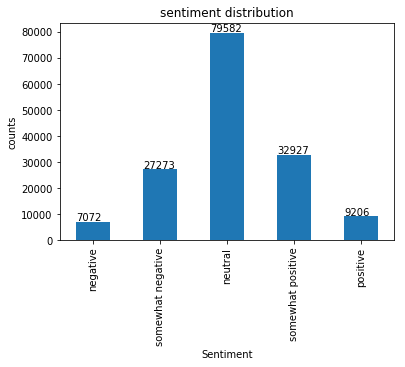

In [18]:
#Distribution of movie reviews with sentiments
tempCount = sentDist = trainTable['Sentiment'].value_counts().sort_index() #sentiment Distribution
sentDist = sentDist.plot.bar(title ='sentiment distribution')
sentDist.set_xticklabels(('negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'))
sentDist.set_xlabel('Sentiment')
sentDist.set_ylabel('counts')
for i,j in enumerate(tempCount):
  sentDist.text(i-0.25,j+450,str(j))

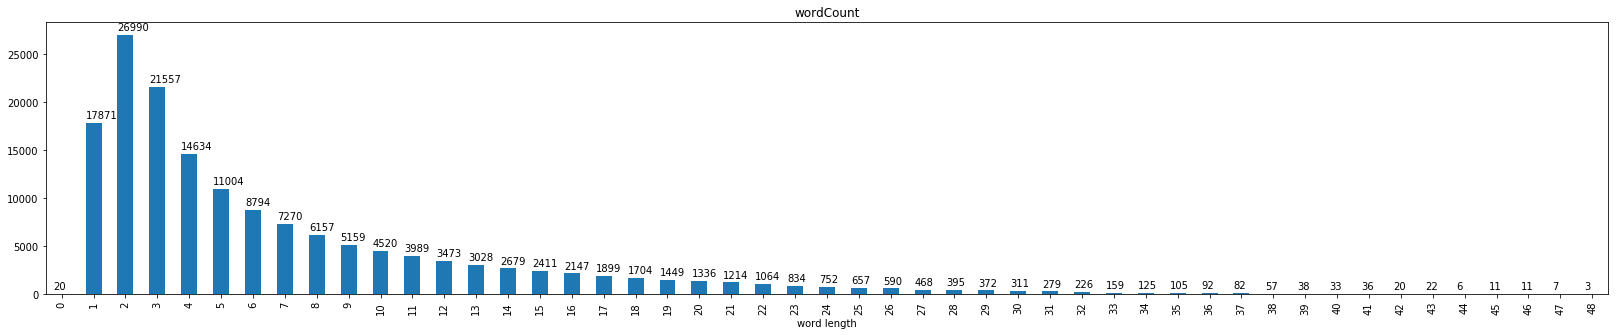

In [19]:
#Distribution of word count
trainTable['proData'] = preProcess(trainTable['Phrase'])
wordCount = trainTable['proData'].apply(lambda x:len(x.split()))
tempCount = wordCount = wordCount.value_counts().sort_index()
maxIndex = max(tempCount.index)
wordCount = wordCount.plot.bar(figsize=[28,5],title ='wordCount')
wordCount.set_xlabel('word length')
for i,j in enumerate(tempCount):
  wordCount.text(i-0.25,j+500,str(j))

In [0]:
# Preprocessing Train Data
xTrain = preProcess(trainTable['Phrase'])
yTrain = trainTable['Sentiment']
yTrain = [to_categorical(i,num_classes=5)for i in yTrain]
t.fit_on_texts(xTrain)
xTrain = sequenceAndPadding(xTrain,maxIndex)

In [37]:
# Model (Bi-LSTM with Softmax) 
embedInDim = len(t.word_index)+1
embedOutDim = 100
model = Sequential()
model.add(Embedding(embedInDim,embedOutDim,input_length=maxIndex))
model.add(Bidirectional(LSTM(units = 64,return_sequences = True,recurrent_dropout = 0.1)))
model.add(Flatten())
model.add(Dense(5,activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 48, 100)           1637800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 48, 128)           84480     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30725     
Total params: 1,753,005
Trainable params: 1,753,005
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
#training
model.fit(xTrain,np.array(yTrain),batch_size=64,epochs=10,verbose=1,validation_split=0.0)


Epoch 1/10
156060/156060 [==============================] - 385s 2ms/step - loss: 0.9275 - acc: 0.6235
Epoch 2/10
156060/156060 [==============================] - 383s 2ms/step - loss: 0.7449 - acc: 0.6930
Epoch 3/10
156060/156060 [==============================] - 383s 2ms/step - loss: 0.6722 - acc: 0.7189
Epoch 4/10
156060/156060 [==============================] - 383s 2ms/step - loss: 0.6243 - acc: 0.7350
Epoch 5/10
156060/156060 [==============================] - 384s 2ms/step - loss: 0.5858 - acc: 0.7486
Epoch 6/10
156060/156060 [==============================] - 384s 2ms/step - loss: 0.5534 - acc: 0.7609
Epoch 7/10
156060/156060 [==============================] - 383s 2ms/step - loss: 0.5237 - acc: 0.7708
Epoch 8/10
156060/156060 [==============================] - 384s 2ms/step - loss: 0.4954 - acc: 0.7821
Epoch 9/10
156060/156060 [==============================] - 385s 2ms/step - loss: 0.4694 - acc: 0.7918
Epoch 10/10
156060/156060 [==============================] - 384s 2ms/ste

In [0]:
#Predicting the output
xTest = preProcess(testTable['Phrase'])
xTest = sequenceAndPadding(xTest,maxIndex)

In [0]:
#prediction
prediction = model.predict_classes(xTest)


In [0]:
#saving the file
sampleTable.Sentiment = prediction 
sampleTable.to_csv(r'results.csv', sep=',', index=False)
files.download('results.csv')